# Bharat Raman - Machine Learning Engineer - Capstone Project 2019

## Project overview
For this project, I will be using the [5000 movies dataset][db], and supervised learning, to predict the user score for a film. The motivation behind this project comes from my [benchmark model][kernel], by Ashwini Swain; here, Swain makes accurate movie-score predictions (average accuracy of about 98.5% among three movies (Godfather Part 3, Minions, Rocky Balboa)) by comparing films' genres, actors, directors, and keywords. Then, to predict the average, Swain does the following:
- Calculate the cosine similarity among other movies
  - First by creating binary-arrays for the lists of genres, actors, directors, and keywords
  - Then, by using scipy's cosine similarity method to compare the arrays with those of other movies
- Takes the top 10 similar movies
- Calculates the average of these 10 movies' user scores
- Uses that average as the prediction for the subject movie's score
I used his algortihm with 10 random movies to get an average accuracy of about 87%. Because it takes too long to predict the score of all movies in the dataset, it must be noted that this score may or may not represent the overall accuracy of all movie predictions

For my project, instead of using a cosine-similarity algorithm, I will use machine learning to predict a movie's score. To do this, I will: 
- create a decimal representation of the features: genres, actors, directors, keywords, and production companies
  - Like Swain has done, I will create a binary array for each feature. Then, I will analyze the array like points in a number line
    - Looking at the points, I can identify a point that best describes the distribution of 1's, and use that as a decimal representation of the feature
- normalize the decimal values to be within [0,1]
- Split data into training and testing sets
  - 70% for training, 30% for testing
- Train a regression-based model using Sagemaker's XGBoost
- Make predictions and evaluate using an R^2 score
- Tune hyperparameters to improve model and re-evaluate R^2 score

I will only use movies that fall under this criteria
 - Rating of movie is greater than 0.0 (0,0 rating corresponds to movies with 0 or 1 votes, so there's no telling if the rating is an accurate representation of the movie)
 - Movie has at least one of the following features: cast, crew, production companies
[//]: # (These are reference links used in the body of this note and get stripped out when the markdown processor does its job. There is no need to format nicely because it shouldn't be seen. Thanks SO - http://stackoverflow.com/questions/4823468/store-comments-in-markdown-syntax)


   [kernel]: <https://www.kaggle.com/ash316/what-s-my-score>
   [db]: <https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv>

## Setup
### Import Modules

In [1]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import json #converting JSON to lists for dataframe
import warnings
warnings.filterwarnings('ignore')
import base64
import codecs
from IPython.display import HTML

%matplotlib inline

In [2]:
movie1=pd.read_csv('./movie_data/tmdb_5000_movies.csv')
movie2=pd.read_csv('./movie_data/tmdb_5000_credits.csv')

movies = movie1.merge(movie2,left_on='id',right_on='movie_id',how='left')# merging the two csv files

### Proof that movies with 0.0 rating only have vote count of 0 or 1

In [3]:
counts = movies[(movies['vote_average']==0)]['vote_count'] # get vote counts for all movies that have a rating of 0.0

print("Unique vote counts for movies with 0.0 rating")
for u in set(counts):
    print(u)

Unique vote counts for movies with 0.0 rating
0
1


### Remove 0.0 rated movies from dataframe

In [4]:
movies = movies[(movies['vote_average']!=0)]

Quick look at movies

In [5]:
movies.sample(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
3143,9500000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://www.mgm.com/view/movie/2347/You-Only-Li...,667,"[{""id"": 212, ""name"": ""london england""}, {""id"":...",en,You Only Live Twice,A mysterious space craft kidnaps a Russian and...,28.675891,"[{""name"": ""Eon Productions"", ""id"": 7576}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,You Only Live Twice...and Twice is the only wa...,You Only Live Twice,6.5,531,667,You Only Live Twice,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""52fe4267c3a36847f801bbd1"", ""de..."
1965,8200000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10751, ""n...",NaN,1788,"[{""id"": 246, ""name"": ""dancing""}, {""id"": 733, ""...",en,Footloose,When teenager Ren and his family move from big...,25.034140,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Footloose,6.4,505,1788,Footloose,"[{""cast_id"": 1, ""character"": ""Ren McCormack"", ...","[{""credit_id"": ""52fe4315c3a36847f8039007"", ""de..."
186,130000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",NaN,8961,"[{""id"": 416, ""name"": ""miami""}, {""id"": 529, ""na...",en,Bad Boys II,"Out-of-control, trash-talking buddy cops Marcu...",38.068736,"[{""name"": ""Columbia Pictures Corporation"", ""id...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"If you can't stand the heat, get out of Miami.",Bad Boys II,6.3,1564,8961,Bad Boys II,"[{""cast_id"": 3, ""character"": ""Detective Marcus...","[{""credit_id"": ""52fe44ccc3a36847f80aa787"", ""de..."
4016,2500000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www2.foxsearchlight.com/gardenstate/,401,"[{""id"": 586, ""name"": ""new jersey""}, {""id"": 856...",en,Garden State,Andrew returns to his hometown for the funeral...,30.583959,"[{""name"": ""Fox Searchlight Pictures"", ""id"": 43...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Garden State,7.1,618,401,Garden State,"[{""cast_id"": 1, ""character"": ""Andrew Largeman""...","[{""credit_id"": ""52fe423fc3a36847f800f449"", ""de..."
2388,18000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,332411,"[{""id"": 9748, ""name"": ""revenge""}, {""id"": 9826,...",en,I Am Wrath,A man is out for justice after a group of corr...,10.144222,"[{""name"": ""Patriot Pictures"", ""id"": 2373}, {""n...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,I lay my vengeance upon them.,I Am Wrath,4.5,179,332411,I Am Wrath,"[{""cast_id"": 3, ""character"": ""Stanley Hill"", ""...","[{""credit_id"": ""56c5999b9251415475000194"", ""de..."


### Step 1: Format dataframe
Features: **genres, keywords, cast, crew, and production companies** are all in JSON format. Convert to simple list via following function

In [6]:
def to_list(df, feature_names_list): #df: dataframe, feature_names: list of all features to convert from JSON to list
    for feature_name in feature_names_list:
        print("Current:", feature_name)
        #STEP 1: convert JSON format to a list
        df[feature_name]=df[feature_name].apply(json.loads)
        #Two cases here: Feature is crew, or feature is not crew
        if feature_name == 'crew': #if crew, due to large size, want to limit to most influential members: director, editor, cinematographer, screenplay, and composer
            for index,i in zip(df.index,df[feature_name]):
                feature_list_1=[]
                limit = 10
                if len(i) < 10:
                    limit = len(i)
                for j in range(limit): #top 10 crew members
                    feature_list_1.append((i[j]['name'])) # the key 'name' contains the name of the a sub-feature (ex: sci-fi in genres)
                df.loc[index,feature_name]= str(feature_list_1)
        
        elif feature_name == 'cast': #Another special case. Only want top 5 cast members (most infulential)
            for index,i in zip(df.index,df[feature_name]):
                feature_list_1=[]
                if len(i) > 5:
                    limit = 5
                else:
                    limit = len(i)
                for j in range(limit): #top 5 (JSON format already has this sorted)
                    feature_list_1.append((i[j]['name']))
                df.loc[index,feature_name]= str(feature_list_1)
        else:    
            for index,i in zip(df.index,df[feature_name]):
                feature_list_1=[]
                for j in range(len(i)):
                    feature_list_1.append((i[j]['name']))
                df.loc[index,feature_name]= str(feature_list_1)
    
        #STEP 2: clean up and transform into unsorted list
        df[feature_name] = df[feature_name].str.strip('[]').str.replace(' ','').str.replace("'",'')
        df[feature_name] = df[feature_name].str.split(',')
        
        #STEP 3: Sort list elements
        for i,j in zip(df[feature_name],df.index):
            features_list_2=i
            features_list_2.sort()
            df.loc[j,feature_name]=str(features_list_2)
        df[feature_name]=df[feature_name].str.strip('[]').str.replace(' ','').str.replace("'",'')
        lst = df[feature_name].str.split(',')
        if len(lst) == 0:
            df[feature_name] = None
        else:
            df[feature_name]= df[feature_name].str.split(',')
    return df

In [7]:
movies = to_list(movies, ['genres', 'keywords', 'production_companies', 'cast', 'crew']) #function call

Current: genres
Current: keywords
Current: production_companies
Current: cast
Current: crew


### Step 2: Remove movies with empty features

If a movie has no information on cast, crew, and production companies, the movie does not match the criteria for a valid datapoint (There's nothing to take away from a movie with no cast, crew, or production company). So, remove movie(s) from dataset

In [8]:
to_drop = []
for i in movies.index:
    if (movies['production_companies'][i] == [''] and movies['cast'][i] == [''] and 
        movies['crew'][i] == ['']):
        to_drop.append(i)
print('Dropping', str(len(to_drop)), 'movies.')
movies = movies.drop(to_drop, axis = 0)

Dropping 8 movies.


In [9]:
movies.shape[0]

4732

#### Remove un-needed feature-types in dataframe

In [10]:
movies_shortened = movies[['id','original_title','genres','cast', 'crew', 'production_companies', 'keywords', 'vote_average']]

Quick look at shortened and formatted movies

In [11]:
movies_shortened.sample(10)

,id,original_title,genres,cast,crew,production_companies,keywords,vote_average
3682,300706,Let's Kill Ward's Wife,[Comedy],"[AmyAcker, DagmaraDomińczyk, DonaldFaison, Pat...","[ScottFoley, ScottFoley]",[LostRhinoFilms],"[murderplot, wifemurder]",5.5
4424,287524,Fear Clinic,[Horror],"[CleopatraColeman, FionaDourif, KevinGage, Rob...","[AaronDrane, AaronDrane, JosephWhite, MarkBent...","[AnchorBayEntertainment, DryCountyFilms, Movie...","[doctor, fear, phobia]",4.0
3629,13996,Bottle Shock,"[Comedy, Drama]","[AlanRickman, BillPullman, ChrisPine, FreddyRo...","[JodySavin, RandallMiller, RandallMiller]","[IntellectualPropertiesWorldwide, ZininsaFilmP...","[wine, winegarden, winzer]",6.6
3919,15582,Teen Wolf Too,"[Comedy, Family, Fantasy]","[EsteeChandler, JasonBateman, JohnAstin, KimDa...","[ChristopherLeitch, CynthiaMcCormac, HarveyRos...",[AtlanticEntertainmentGroup],"[teenager, werewolf]",3.8
1592,4105,Black Rain,"[Action, Crime, Thriller]","[AndyGarcía, JohnSpencer, KateCapshaw, Michael...","[DianneCrittenden, EllenMirojnick, HansZimmer,...","[Jaffe-Lansing, ParamountPictures, PegasusFilm...","[japan, japanesemafia, yakuza]",6.2
1574,8780,Baby Mama,[Comedy],"[AmyPoehler, DaxShepard, GregKinnear, Sigourne...","[AvyKaufman, BruceGreen, DarynOkada, JeffRichm...","[Michaels-Goldwyn, RelativityMedia]","[pregnancyandbirth, surrogatemother]",5.8
2599,15237,De-Lovely,"[Drama, Music]","[AshleyJudd, JonathanPryce, KevinKline, KevinM...","[AndrewGrant, CharlesWinkler, EveStewart, Irwi...","[Metro-Goldwyn-Mayer(MGM), PotboilerProduction...","[biography, hollywood, musical, theater]",6.3
3966,26039,Point Blank,"[Action, Crime, Drama, Thriller]","[""CarrollOConnor"", AngieDickinson, KeenanWynn,...","[AlbertBrenner, EdwardWoehler, GeorgeW.Davis, ...","[Metro-Goldwyn-Mayer(MGM), WinklerFilms]","[alcatraz, organizedcrime, revenge]",7.1
3890,10162,Waking Ned,"[Comedy, Romance]","[BrendanDempsey, DavidKelly, FionnulaFlanagan,...","[AlanStrachan, AlexandreHeylen, GlynisMurray, ...","[Canal+, FoxSearchlightPictures, TomboyFilms]","[beguilement, falseidentity, independentfilm, ...",7.4
690,497,The Green Mile,"[Crime, Drama, Fantasy]","[BonnieHunt, DavidMorse, JamesCromwell, Michae...","[DavidValdes, FrankDarabont, FrankDarabont, Fr...","[CastleRockEntertainment, DarkwoodsProductions...","[1930s, basedonnovel, blackpeople, deathrow, d...",8.2


### Looking at distribution of Movie ratings:
- Histogram of distribution
- minimum of ratings
- maximum of ratings
- mean and variance

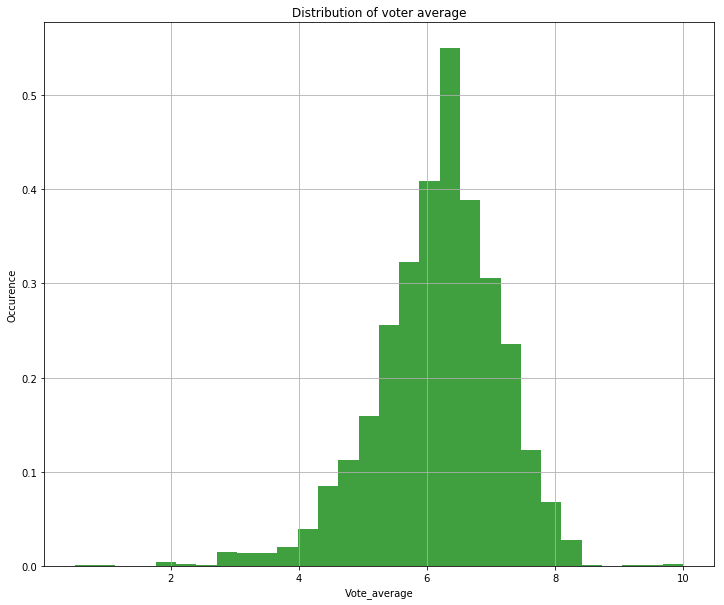

Minimum of Ratings: 0.5
Maximum of Ratings: 10.0
Average of Ratings: 6.17
Variance of Ratings: 0.93


In [73]:
plt.subplots(figsize=(12,10))
n, bins, patches = plt.hist(movies_shortened['vote_average'], 30, density=1, facecolor='g', alpha=0.75)

plt.xlabel('Vote_average')
plt.ylabel('Occurence')
plt.title('Distribution of voter average')
plt.grid(True)
plt.show()
print("Minimum of Ratings:", round(min(movies_shortened['vote_average']),2))
print("Maximum of Ratings:", round(max(movies_shortened['vote_average']),2))
print("Average of Ratings:", round(np.mean(movies_shortened['vote_average']),2))
print("Variance of Ratings:",round(np.var(movies_shortened['vote_average']),2))

## Feature Engineering: Turn lists of features into numerical representations

### Step 1: Identify all unique sub-feature for each feature (ex: all unique cast members in the cast category)
#### Organize sub-features to lowest-rating association to highest-rating association
By organizing features in this order, the numerical representation will then also describe the quality of features associated with the movie
- higher quality feature values should correlate with higher-rated movies, and vice versa

In [12]:
def generate_list(df, feature_name): #create a list of all unique feature values
    #Step 1: track all ratings associated with each feature in a dictionary
    feature_dict = {}
    for index, row in df.iterrows():
        feat = row[feature_name]
        for sub_feat in feat:
            if sub_feat not in feature_dict:
                feature_dict[sub_feat] = (df['vote_average'][index], 1) #
            else:
                feature_dict[sub_feat] = (feature_dict[sub_feat][0] + (df['vote_average'][index]), feature_dict[sub_feat][1] + 1)
    #Step 2: calculate average ratings for each feature
    for key in feature_dict:
        feature_dict[key] = feature_dict[key][0]/feature_dict[key][1] #average of all vote_averages
       
    #Step 3: create and sort a list of tuples (dictionary value, key)
    lst = list()
    for name in feature_dict:
        lst.append((feature_dict[name],name))
    lst = sorted(lst)
    #step 4: create a list of only the feature names, from lowest rating to highest rating
    feature_list = list()
    ratings_list = list()
    for element in lst:
        feature_list.append(element[1])
        ratings_list.append(element[0])
    
    #get the variance of the ratings. This is helpful for determining the usefulness of the information (to be displayed in below plot)
    var = round(np.var(ratings_list),3)
    
    #before returning the list, do a quick visualization to show that generate_list works
    fig, ax = plt.subplots(figsize=(6,5))
    if feature_name != 'genres':
        n = 50 # sample at intervals of n
    else:
        n = 1
    X = [] #sample for associated movie(s) rating average
    Y = [] #sample for feature names
    for i in range(0, len(feature_list) - 1, n):
        X.append(ratings_list[i])
        Y.append(feature_list[i])
    
    y_pos = np.arange(len(Y))
    ax.barh(y_pos, X, align='center')
    #ax.set_yticklabels(Y)
    ax.invert_yaxis()  # labels read top-to-bottom
    
    ax.set_xlabel('Overall average movie ratings')
    ax.set_ylabel(feature_name + ' sample list index')
    ax.set_title(feature_name + ' to associated movie(s) performance (' + str(int(len(feature_list)/n)) + ' samples), variance: ' + str(var))
    
    plt.show()
    
    return feature_list


### Create lists for each feature

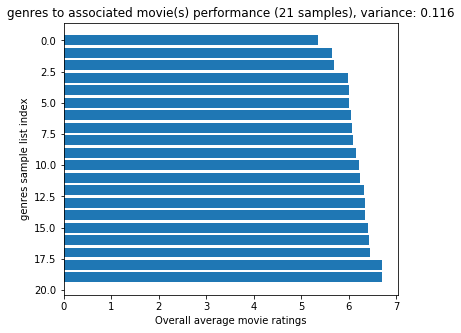

In [13]:
genres_list = generate_list(movies_shortened, 'genres')

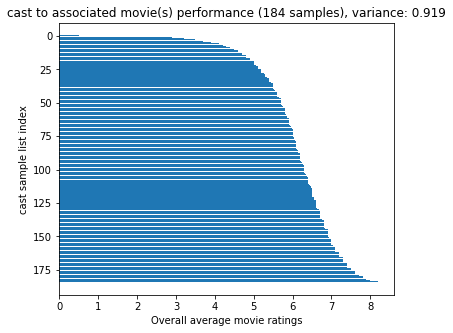

In [14]:
cast_list = generate_list(movies_shortened, 'cast')

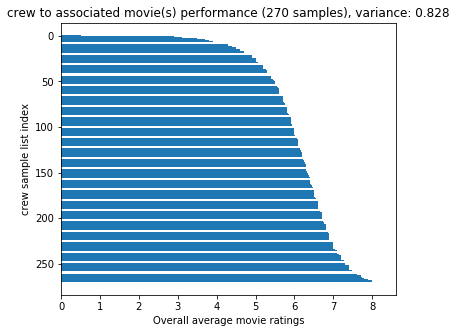

In [15]:
crew_list = generate_list(movies_shortened, 'crew')

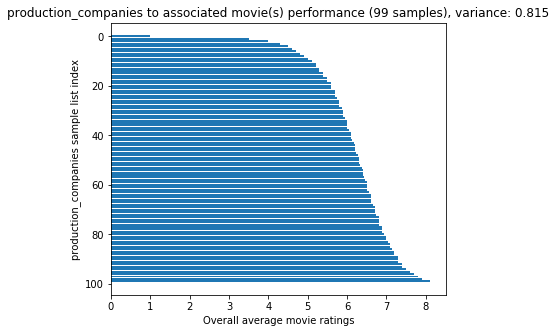

In [16]:
prod_companies_list = generate_list(movies_shortened, 'production_companies')

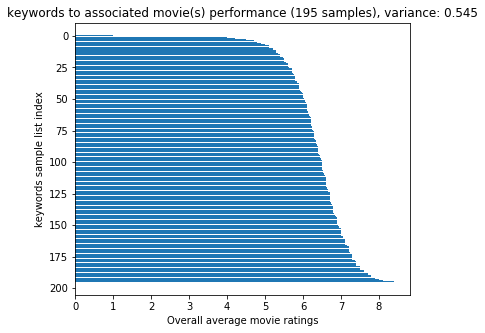

In [17]:
keywords_list = generate_list(movies_shortened, 'keywords')

### Analysis

Judging by the above variances, it's safe to say that **genres** will not be useful for predicting a movie's vote-average
The features **cast, crew, production companies, and keywords** have high variances, which will be useful

In [18]:
movies_shortened = movies_shortened[['id', 'original_title', 'cast', 'crew', 'production_companies', 'keywords','vote_average']]

### Step 2: Create a binary representation for each feature

##### Using the lists created, create binary arrays that indicated whether or not feature_name can be found in this movie

note: each array represents a feature associated with movies with lowest average ratings to highest average ratings
- this is useful because we can use the array as a gauge for how well the features track record in movies are

In [19]:
def calculate_bin_array(this_list, all_features):
    bin_list = []
    for element in all_features:
        if element in this_list:
            bin_list.append(1)
        else:
            bin_list.append(0)
    return bin_list

In [20]:
movies_shortened['cast'] = movies_shortened['cast'].apply(lambda x: calculate_bin_array(x, cast_list))

In [21]:
movies_shortened['crew'] = movies_shortened['crew'].apply(lambda x: calculate_bin_array(x, crew_list))

In [22]:
movies_shortened['production_companies'] = movies_shortened['production_companies'].apply(lambda x: calculate_bin_array(x, prod_companies_list))

In [23]:
movies_shortened['keywords'] = movies_shortened['keywords'].apply(lambda x: calculate_bin_array(x, keywords_list))

In [24]:
movies_shortened.head()

,id,original_title,cast,crew,production_companies,keywords,vote_average
0,19995,Avatar,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.2
1,285,Pirates of the Caribbean: At World's End,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.9
2,206647,Spectre,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.3
3,49026,The Dark Knight Rises,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.6
4,49529,John Carter,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.1


### Look at distribution of 1's in a number-line format

In [25]:
def plot_bin(mov):
    cast_bin = mov[2]
    cast_index = []
    # create arrays of indeces where bin number is one
    for i in range(len(cast_bin)):
        if cast_bin[i] == 1:
            cast_index.append(i)
    
    crew_bin = mov[3]
    crew_index = []
    for i in range(len(crew_bin)):
        if crew_bin[i] == 1:
            crew_index.append(i)
    
    prod_bin = mov[4]
    prod_index = []
    for i in range(len(prod_bin)):
        if prod_bin[i] == 1:
            prod_index.append(i)
    
    keywords_bin = mov[5]
    keywords_index = []
    for i in range(len(keywords_bin)):
        if keywords_bin[i] == 1:
            keywords_index.append(i)
    
    font = {'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 10,
        }
    
    fig, ax = plt.subplots(4,1,figsize=(5,1))
    plt.subplots_adjust(hspace = 5)
    ax[0].scatter(cast_index, np.zeros_like(cast_index), vmin=-2)
    ax[0].set_title('Cast', loc = 'left', fontdict=font)
    ax[0].set_xlim(0,len(cast_bin))
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    
    ax[1].scatter(crew_index, np.zeros_like(crew_index), vmin=-2)
    ax[1].set_title('Crew', loc = 'left', fontdict=font)
    ax[1].set_xlim(0,len(crew_bin))
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    
    ax[2].scatter(prod_index, np.zeros_like(prod_index), vmin=-2)
    ax[2].set_title('Production companies', loc = 'left', fontdict=font)
    ax[2].set_xlim(0,len(prod_bin))
    ax[2].set_yticks([])
    ax[2].set_xticks([])
    
    ax[3].scatter(keywords_index, np.zeros_like(keywords_index), vmin=-2)
    ax[3].set_title('Keywords', loc = 'left', fontdict=font)
    ax[3].set_xlim(0,len(keywords_bin))
    ax[3].set_yticks([])
    ax[3].set_xticks([])


In [26]:
movies_sample = movies_shortened.sample(5)

Movie: Resident Evil: Retribution
Rating: 5.6



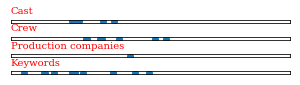

In [27]:
print('Movie: ' + movies_sample.iloc[0][1] + '\nRating: ' + str(movies_sample.iloc[0][-1]) + '\n')
plot_bin(movies_sample.iloc[0])

Movie:A Bridge Too Far
Rating: 6.9



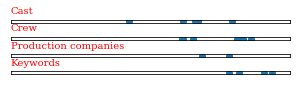

In [28]:
print('Movie:' + movies_sample.iloc[1][1] + '\nRating: ' + str(movies_sample.iloc[1][-1]) + '\n')
plot_bin(movies_sample.iloc[1])

Movie:National Treasure
Rating: 6.4



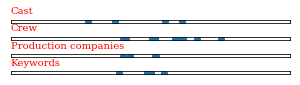

In [29]:
print('Movie:' + movies_sample.iloc[2][1] + '\nRating: ' + str(movies_sample.iloc[2][-1]) + '\n')
plot_bin(movies_sample.iloc[2])

Movie:Brooklyn's Finest
Rating: 6.2



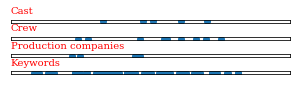

In [30]:
print('Movie:' + movies_sample.iloc[3][1] + '\nRating: ' + str(movies_sample.iloc[3][-1]) + '\n')
plot_bin(movies_sample.iloc[3])

Movie:Joan of Arc
Rating: 6.2



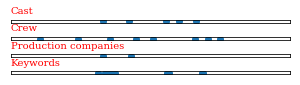

In [31]:
print('Movie:' + movies_sample.iloc[4][1] + '\nRating: ' + str(movies_sample.iloc[4][-1]) + '\n')
plot_bin(movies_sample.iloc[4])

#### Analysis
 - Movies with lower ratings have features leaning towards the left, while movies with higher ratings have features leaning to the right. 
 - This shows that there's a relationship between features and ratings if feature names is organized from lowest movie rating associations to highest movie rating associations

### Step 3: Find concentration points in each array
Find areas where numbers are grouped, and identify points that resemble the centers of binary distribution

    Generic example: [1110001111100101] -> [0300000050000020] -> [(1,3), (8,5), (14,2)] tuple[0] is the index of concentration, tuple[1] is the number of 1's about index

In [32]:
def split_arr(arr, n_splits): 
      
    # looping till length l 
    for i in range(0, len(arr), n_splits):  
        yield arr[i:i + n_splits] 

def find_concentration(arr, n = 100): # n is the number of concentration points to find
    #seperate array into batches
    batches = list(split_arr(arr,int(len(arr)/n)))
    concentrations = []
    for i in range(len(batches)):
        point = 0
        num_ones = 0
        for j in range(len(batches[i])):
            if batches[i][j] == 1:
                point += j + (i * int(len(arr)/n)) # adding correction for batches
                num_ones += 1
        if num_ones > 0:
            point = point/num_ones
            concentrations.append((point,num_ones))
    return concentrations

In [33]:
def to_concentrations(df, feature_names):
    for feature_name in feature_names:
        print('feature: ', feature_name)
        df[feature_name] = df[feature_name].apply(lambda x: find_concentration(x))
    return df

In [34]:
movies_shortened = to_concentrations(movies_shortened, ['cast', 'crew', 'production_companies', 'keywords'])

feature:  cast
feature:  crew
feature:  production_companies
feature:  keywords


In [35]:
movies_shortened.sample(10)

,id,original_title,cast,crew,production_companies,keywords,vote_average
4584,189711,Love in the Time of Monsters,"[(781.0, 1), (918.0, 1), (993.0, 1), (1038.0, ...","[(1352.5, 2)]","[(458.0, 2)]","[(1295.0, 1)]",5.0
444,4147,Road to Perdition,"[(3855.0, 1), (6447.0, 1), (7857.5, 2), (8447....","[(7447.0, 1), (8847.0, 1), (9507.0, 1), (9667....","[(2156.0, 1), (2917.0, 1), (3402.0, 1)]","[(6744.0, 1), (8693.5, 2), (8780.714285714286,...",7.3
1693,11249,Seed of Chucky,"[(1103.0, 1), (1774.0, 1), (2205.0, 1), (3105....","[(1159.0, 3), (2455.0, 1), (5774.0, 1), (6300....","[(932.0, 1)]","[(279.0, 2), (683.0, 1), (1061.0, 1), (1146.0,...",4.9
1057,7214,Coach Carter,"[(4344.0, 1), (4711.0, 1), (4811.0, 1), (7538....","[(4269.0, 1), (4384.0, 1), (5498.5, 2), (6283....","[(2083.0, 1), (2363.0, 1), (2555.0, 1)]","[(1894.0, 1), (3155.0, 1), (3636.0, 1), (3812....",7.3
4131,335866,Circle,"[(1806.0, 1), (2031.0, 1), (2999.0, 1), (3519....","[(5048.0, 1), (5294.0, 1)]","[(1857.0, 1), (2632.0, 1)]","[(2412.0, 1), (5370.0, 1), (5978.0, 1), (6040....",6.0
1423,14442,Ella Enchanted,"[(3194.0, 1), (3842.0, 1), (3938.0, 2), (6137....","[(5482.0, 1), (5652.0, 1), (6179.0, 1), (6979....","[(1508.0, 1), (2834.0, 1)]","[(1366.0, 1), (1974.0, 1), (2101.0, 1), (2255....",5.9
3341,77930,Magic Mike,"[(1816.0, 1), (2510.0, 1), (3931.0, 1), (4811....","[(3682.0, 1), (4397.0, 1), (4975.0, 1), (5789....","[(1972.0, 1), (2388.0, 1)]","[(2553.0, 1), (4084.0, 1), (4345.0, 1), (4766....",6.1
537,37958,Immortals,"[(1104.0, 1), (2992.0, 1), (3404.0, 1), (3653....","[(2854.0, 2), (3695.0, 1), (4247.0, 1), (4395....","[(942.0, 1), (2263.0, 1)]","[(681.0, 1), (1779.0, 1), (2154.0, 1), (5400.0...",5.7
3785,48309,Prison,"[(5334.0, 1), (6051.0, 1), (6088.0, 1), (6701....","[(2403.0, 1), (4291.0, 1), (8448.0, 1), (9772....","[(2873.0, 1)]","[(1817.0, 1), (3137.0, 1), (3714.0, 1), (4867....",6.7
3937,10683,Happiness,"[(4020.0, 1), (4379.0, 1), (5824.0, 1), (6872....","[(8339.0, 1), (9156.0, 1), (9550.0, 1), (10810...","[(3126.0, 1), (3836.0, 1)]","[(3432.0, 1), (3634.0, 1), (3735.0, 1), (3814....",7.4


### Step 3.1: Find a decimal value that represents the concentration points
The point will represent the weighted average of all points of concentration
The weight is the number of ones for each concentration point

In [36]:
def w_avg(arr):
    weight = 0 #weight
    s = 0 # position*weight
    for element in arr:
        s += (element[0] * element[1])
        weight += element[1]
    return s/weight #weighted average

In [37]:
def to_weighted_avg(df, feature_names):
    for feature_name in feature_names:
        print('Current: ', feature_name)
        df[feature_name] = df[feature_name].apply(lambda x: w_avg(x))
    return df

In [38]:
movies_shortened = to_weighted_avg(movies_shortened, ['cast', 'crew', 'production_companies', 'keywords'])

Current:  cast
Current:  crew
Current:  production_companies
Current:  keywords


In [39]:
movies_shortened['vote_average'] = movies['vote_average']

In [40]:
movies_shortened.sample(10)

,id,original_title,cast,crew,production_companies,keywords,vote_average
2040,2176,The Glass House,4132.8,4252.700000,1434.000000,3831.428571,5.4
1650,10350,Wing Commander,2540.2,2951.400000,390.000000,2777.000000,4.0
689,14306,Marley & Me,4281.0,7333.777778,1902.500000,4401.571429,6.9
3159,30497,The Texas Chain Saw Massacre,7514.2,9980.166667,3275.500000,5411.187500,7.2
678,300168,天將雄師,4191.6,4564.555556,1992.777778,1295.000000,5.9
1502,11978,Men of Honor,5111.2,7216.363636,2362.000000,3440.500000,7.0
2756,10691,Crazy/Beautiful,4601.2,6490.100000,2871.000000,5233.545455,6.6
380,921,Cinderella Man,5500.6,9162.000000,2918.000000,6637.333333,7.3
1334,23742,Cop Out,2506.2,4999.250000,2634.000000,3341.200000,5.3
4592,3059,Intolerance,8579.8,12689.888889,4647.500000,7216.076923,7.4


### Step 4: Normalize the features

First, make a dataframe to isolate the features

In [41]:
feat_df = movies_shortened[['cast', 'crew', 'production_companies', 'keywords']] #extract only features from df, and scale

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat_scaled = pd.DataFrame(scaler.fit_transform(feat_df.astype(float)))
feat_scaled.index = feat_df.index
feat_scaled.columns = feat_df.columns

#Seperate dataframe for target
target_df = pd.DataFrame()
target_df['ratings'] =  movies_shortened['vote_average']

In [43]:
feat_scaled.sample(10)

,cast,crew,production_companies,keywords
3458,0.619049,0.701593,0.305032,0.273883
2354,0.607477,0.708616,0.550889,0.591153
3093,0.601594,0.718649,0.406208,0.555221
515,0.411997,0.513276,0.408480,0.517623
4779,0.599423,0.885526,0.221131,0.562288
653,0.531513,0.387971,0.262697,0.327673
4534,0.838866,0.829295,0.849439,0.408123
755,0.542237,0.556790,0.473737,0.518133
1850,0.651115,0.781421,0.479952,0.692586
4101,0.315082,0.363272,0.238840,0.394726


### Visualising Features in a Scatterplot

Text(0.5, 0.98, "Corrlation between a movie's features and its rating")

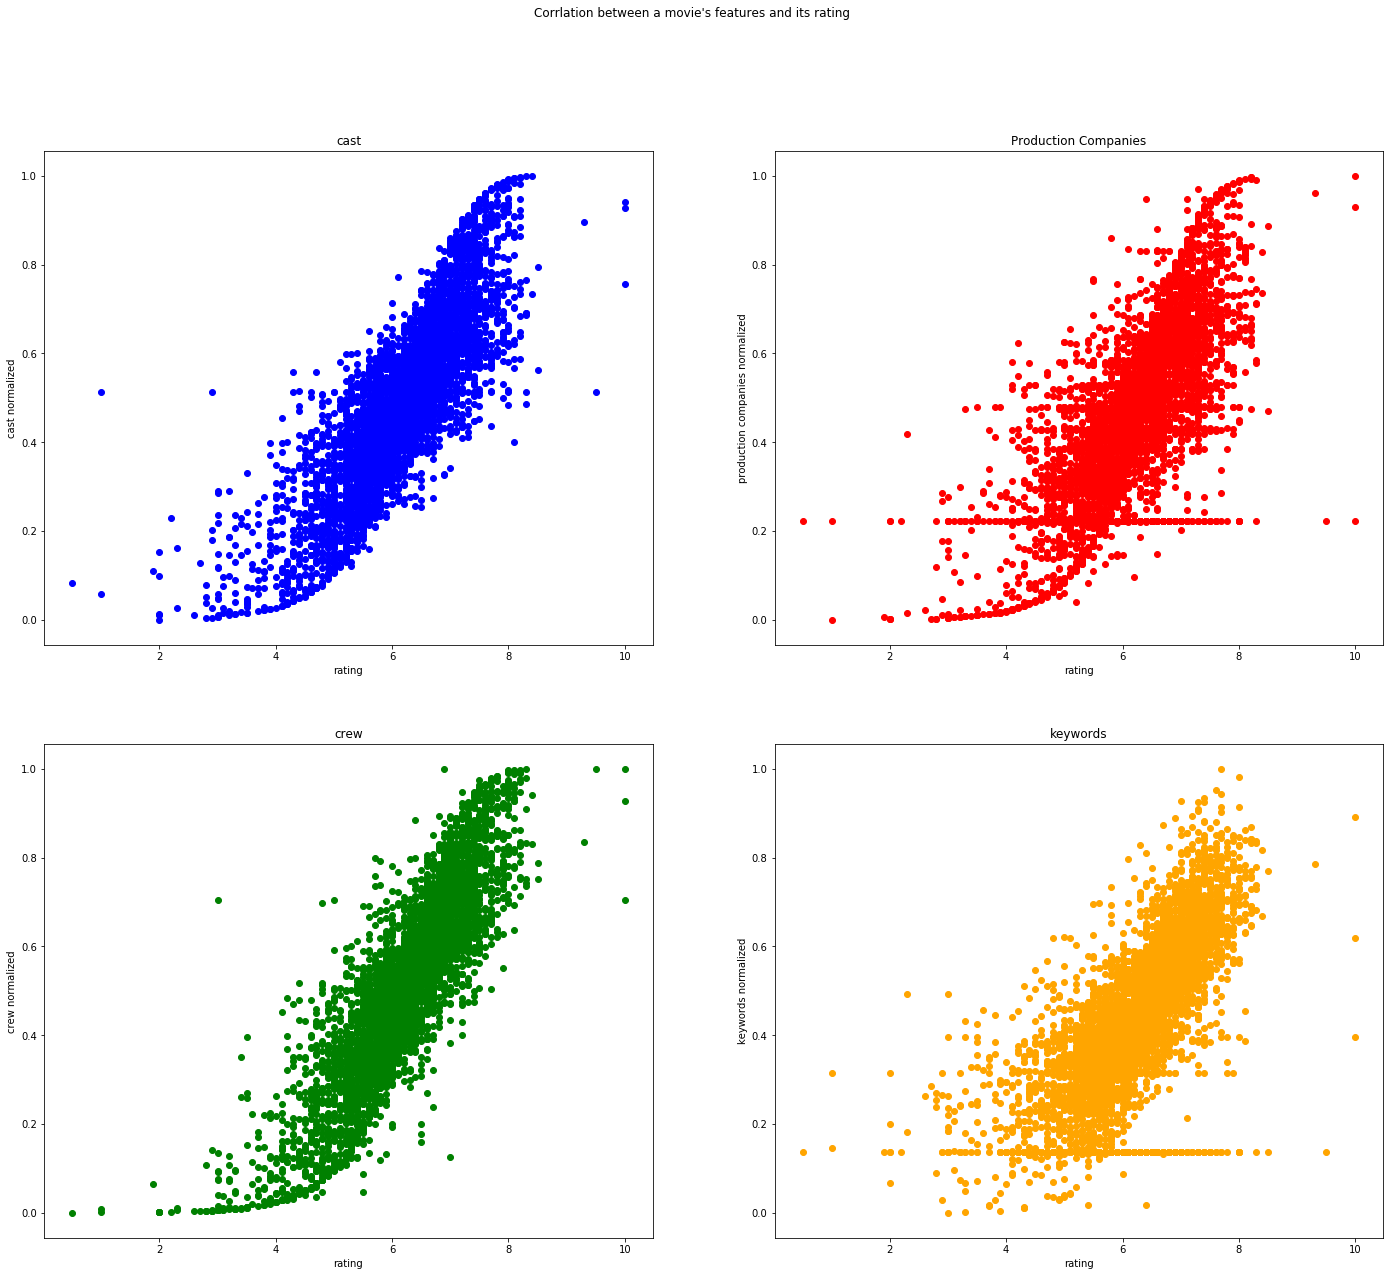

In [44]:
fig, ax = plt.subplots(2,2, figsize=(24,20))

ax[0,0].scatter(target_df['ratings'], feat_scaled['cast'], facecolor='blue')
ax[0,0].set_xlabel('rating')
ax[0,0].set_ylabel('cast normalized')
ax[0,0].set_title('cast')

ax[1,0].scatter(target_df['ratings'], feat_scaled['crew'], facecolor='green')
ax[1,0].set_xlabel('rating')
ax[1,0].set_ylabel('crew normalized')
ax[1,0].set_title('crew')

ax[0,1].scatter(target_df['ratings'], feat_scaled['production_companies'], facecolor='red')
ax[0,1].set_xlabel('rating')
ax[0,1].set_ylabel('production companies normalized')
ax[0,1].set_title('Production Companies')

ax[1,1].scatter(target_df['ratings'], feat_scaled['keywords'], facecolor='orange')
ax[1,1].set_xlabel('rating')
ax[1,1].set_ylabel('keywords normalized')
ax[1,1].set_title('keywords')

fig.suptitle("Corrlation between a movie's features and its rating")

As you can see, there's a clear correlation between the features and the ratings
The straight lines in figures for keywords and production companies represents the absence of keywords and production companies for certain movies

### Split Data into testing and training
Will be splitting trainting : testing : validation -> (0.7) : (0.15) : (0.15)

In [45]:
from sklearn.model_selection import train_test_split
def train_test_val_split(df_feat, df_target, train_frac = 0.33, val_frac = 0.33):
    train_features, rest_features, train_target, rest_target = train_test_split(df_feat, df_target, test_size = train_frac) #splitting training from rest of the dataset
    test_features, val_features, test_target, val_target = train_test_split(rest_features, rest_target, test_size = val_frac) #splitting rest of data into testing and validation
    return (train_features, train_target), (test_features, test_target), (val_features, val_target)

In [46]:
(features_train, target_train), (features_test, target_test), (features_val, target_val) = train_test_val_split(feat_scaled, target_df,0.7,0.5)

In [47]:
print('Test', len(target_test) - len(features_test))
print('Validation',len(target_val) - len(features_val))
print('Train', len(target_train) - len(features_train))

Test 0
Validation 0
Train 0


In [48]:
target_train.head()

,ratings
797,5.1
2167,7.1
2152,7.9
3187,6.1
3524,6.4


## Creating the model

#### Import Sagemaker modules

In [49]:
importimport sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

#### Store Sagemaker variables

In [50]:
# sagemaker session, role
session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = session.default_bucket()


## Model: XGBoost with regression

I will be refering to [this Udacity tutorial][xgb] on Boston housing market, which demonstrates regression using xgboost 

[//]: # (These are reference links used in the body of this note and get stripped out when the markdown processor does its job. There is no need to format nicely because it shouldn't be seen. Thanks SO - http://stackoverflow.com/questions/4823468/store-comments-in-markdown-syntax)


   [xgb]: <https://github.com/udacity/sagemaker-deployment/tree/master/Tutorials>
    

### Upload split data to S3
#### Save Data Locally

In [51]:
#use local directory
data_dir = "./movie_data/split_data"

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [52]:
features_test.to_csv(os.path.join(data_dir,'test.csv'), header = False, index = False)
pd.concat([target_val, features_val], axis=1).to_csv(os.path.join(data_dir,'validation.csv'), header = False, index = False)
pd.concat([target_train, features_train], axis=1).to_csv(os.path.join(data_dir,'train.csv'), header = False, index = False)

#### Upload to S3

In [53]:
prefix = 'movies-xgboost-capstone'
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

### Prepare for Training XGBoost model

In [54]:
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count = 1,
                                    train_instance_type = 'ml.m4.xlarge',
                                    output_path = 's3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session = session)

### Set hyperparameters

In [55]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

### Train

In [56]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-10-29 22:22:26 Starting - Starting the training job...
2019-10-29 22:22:28 Starting - Launching requested ML instances......
2019-10-29 22:23:26 Starting - Preparing the instances for training......
2019-10-29 22:24:46 Downloading - Downloading input data
2019-10-29 22:24:46 Training - Downloading the training image...
2019-10-29 22:25:20 Uploading - Uploading generated training model
2019-10-29 22:25:20 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[22:25:11] 1419x4 matrix with 5676 ent

### Deploy

In [57]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------!

### Evaluate Model

In [58]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

target_pred = xgb_predictor.predict(features_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
target_pred = np.fromstring(target_pred, sep=',')

Text(0.5, 1.0, 'Movie ratings vs Predicted ratings')

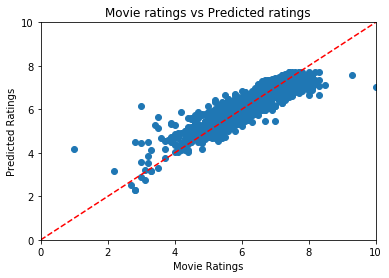

In [61]:
plt.axis([0,10,0,10])
plt.scatter(target_test, target_pred)

index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')             
plt.xlabel("Movie Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Movie ratings vs Predicted ratings")

### R^2 Score

In [62]:
from sklearn.metrics import r2_score

score = r2_score(target_test, target_pred)

print("R^2 Score for predictions:", score)

R^2 Score for predictions: 0.8056118321396382


In [63]:
xgb_predictor.delete_endpoint()

### Remarks
Overall, these predictions are very good. The graph shows that the predicted to actual ratings almost follows a linear 'y = x' path. However, there could be room for improvement.
I will implement a tuning job to see if I can improve the R2 score

### Hyperparameter Tuning
Tuning the hyperparameters:
- max depth
- eta
- min child weight
- subsample
- gamma

In [64]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb,
                                               objective_metric_name = 'validation:rmse', #looking at validation root mean square error in among training jobs
                                               objective_type = 'Minimize', #find training job with minimal rmse
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = { #hyperparameters to tune
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.6),
                                                    'min_child_weight': IntegerParameter(1, 9),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [65]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [66]:
xgb_hyperparameter_tuner.wait()

.......................................................................................................................................................................................................................................................................................!


In [67]:
xgb_predictor_tuned = xgb_hyperparameter_tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

2019-10-29 22:56:39 Starting - Preparing the instances for training
2019-10-29 22:56:39 Downloading - Downloading input data
2019-10-29 22:56:39 Training - Training image download completed. Training in progress.
2019-10-29 22:56:39 Uploading - Uploading generated training model
2019-10-29 22:56:39 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[22:56:28] 1

In [68]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor_tuned.content_type = 'text/csv'
xgb_predictor_tuned.serializer = csv_serializer

target_pred = xgb_predictor_tuned.predict(features_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
target_pred = np.fromstring(target_pred, sep=',')

Text(0.5, 1.0, 'Movie ratings vs Predicted ratings after Tuning')

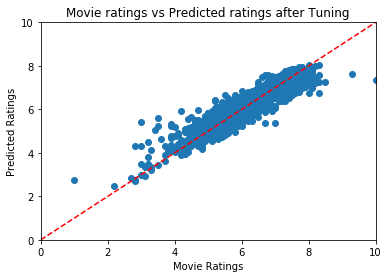

In [69]:
plt.axis([0,10,0,10])
plt.scatter(target_test, target_pred)

index_arr = [n for n in range(11)] #for plotting y = x
plt.plot(index_arr,'r--')             
plt.xlabel("Movie Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Movie ratings vs Predicted ratings after Tuning")

In [70]:
score = r2_score(target_test, target_pred)
print("R^2 Score for predictions:", score)

R^2 Score for predictions: 0.8297857624646012


In [71]:
xgb_predictor_tuned.delete_endpoint()

## Conclusion
The resultant R^2 much better than expected. As an R^2 score is described, approximately 82.98% of the variance in the dependent variable (ratings) can be explained by the independent variables (cast, crew, production companies, and keywords). This shows that machine learning is a viable way of predicting the score of a movie in the tmdb database.

In relation to the benchmark model, an accuracy of 0.83 is comparable to the prediction accuracy with 10 movies in the benchmark, which was around 0.87. But as noted previously, the accuracy score in the benchmark model is not representative of the entire dataset; applying cosine similarity to 4000+ movies will take too much time to be productive.
